<a href="https://colab.research.google.com/github/Kimgabe/AIFFEL_Online_Quest/blob/main/MainQuest3(%EB%B0%91%EC%8B%9C%EB%94%A5_Final)/%5BMain_Quest03_%EC%9E%AC%EB%8F%84%EC%A0%84_%EC%A0%95%ED%99%95%EB%8F%84_99.3%25%5D_%EA%B0%80%EC%9C%84%EB%B0%94%EC%9C%84%EB%B3%B4_%EB%B6%84%EB%A5%98%EA%B8%B0_%EB%A7%8C%EB%93%A4%EA%B3%A0_%EC%84%B1%EB%8A%A5%ED%96%A5%EC%83%81%EC%8B%9C%ED%82%A4%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📌 Intro.
- AIFFEL Core과정 7기의 3번째 메인 퀘스트인 '쫄지말자 딥러닝' 노드의 메인 퀘스트를 지난 금요일(12.15)일에 수행했습니다.
- 여러 문제점들이 있어서 정확도 85%를 달성하는데 실패했는데, 주말을 이용해서 부족한 부분을 보완할겸, 모델 개선작업을 수행합니다.

In [ ]:
# GPU 세팅
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # 메모리 사용 제한을 위한 설정
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # 특정 GPU만 사용하도록 설정
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        # 프로그램 시작 후에는 GPU 설정을 변경할 수 없으므로
        # 런타임 오류 발생 시 예외 처리가 필요함
        print(e)

Num GPUs Available:  1


## 데이터 불러오기 및 데이터셋 구축

- 일단 현재 데이터가 있는 디렉토리는 구조는 아래와 같습니다.

```python
data
└── rock_scissor_paper
    ├── rock
        └── rock.zip
    ├── scissor
        └── scissor.zip
    └── paper
        └── paper.zip
```

- scissor.zip 에서 가위 이미지 한개를 불러와서 shape를 확인해 보겠습니다.

### 생성데이터 압축 풀기

In [ ]:
import os
import shutil
import zipfile

def remove_macosx_folder(folder_path):
    macosx_path = os.path.join(folder_path, '__MACOSX')
    if os.path.exists(macosx_path):
        shutil.rmtree(macosx_path)
        print(f"{folder_path} 내의 __MACOSX 폴더 삭제 완료")

# zip파일의 압축을 해제 하는 함수
def unzip_files(base_path):
    # 각 폴더 이름 base_path 아래 3개의 폴더 이름
    folders = ['scissor', 'rock', 'paper']

    # 폴더 내의 모든 파일 중 .zip 파일을 제외하고 삭제
    for folder in folders:
        # 기본경로에 폴더명 붙여서 경로 생성
        folder_path = os.path.join(base_path, folder)
        # 폴더내 파일의 list 생성
        for filename in os.listdir(folder_path):
            # 각 파일에 대한 경로 생성
            file_path = os.path.join(folder_path, filename)
            # 파일경로내의 파일명이 '.zip' 을 포함하고 있지 않으면
            if not filename.endswith('.zip') and os.path.isfile(file_path):
                os.remove(file_path) # 삭제
                # print(f"{filename} 삭제 완료") # 디버깅용

        # .zip 파일 경로
        zip_file_path = os.path.join(base_path, folder, folder + '.zip')

        # 폴더내에 zip 파일이 존재하는 경우 압축 해제
        if os.path.exists(zip_file_path):
            with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                zip_ref.extractall(os.path.join(base_path, folder))
            remove_macosx_folder(base_path)  # 압축 해제 후 __MACOSX 폴더 삭제
            print(folder + " 압축 해제 완료")
        else:
            print(zip_file_path + " 파일을 찾을 수 없습니다.")


base_path = '../data/rock_scissor_paper'
unzip_files(base_path)

scissor 압축 해제 완료
rock 압축 해제 완료
paper 압축 해제 완료


### 각 폴더별로 데이터 불러오기

In [ ]:
import os

# 데이터 폴더 경로 설정
data_folder = "../data/rock_scissor_paper"

# 폴더 이름 리스트
folder_names = ["scissor", "rock", "paper"]

# 각 폴더에서 확장자가 '.jpg'인 파일 개수 확인
data = {}  # 데이터 개수를 저장할 딕셔너리

for folder_name in folder_names:
    folder_path = os.path.join(data_folder, folder_name)
    file_list = [f for f in os.listdir(folder_path) if f.endswith(".jpg")]
    data[folder_name] = len(file_list)  # 파일 개수를 저장

# 결과 출력
print("scissor 폴더에 있는 .jpg 파일 개수:", data["scissor"])
print("rock 폴더에 있는 .jpg 파일 개수:", data["rock"])
print("paper 폴더에 있는 .jpg 파일 개수:", data["paper"])

scissor 폴더에 있는 .jpg 파일 개수: 100
rock 폴더에 있는 .jpg 파일 개수: 100
paper 폴더에 있는 .jpg 파일 개수: 100


### 데이터의 이미지 및 모양 확인하기

In [ ]:
from PIL import Image
import glob

# 이미지 파일이 저장된 폴더 경로 설정
image_folder = "../data/rock_scissor_paper/scissor" # 확인하려는 폴더를 선택

# glob을 사용하여 특정 패턴과 일치하는 파일 목록을 가져오기
# image_folder 내에서 확장자가 .jpg 인 모든 파일을 가져옴
image_files = glob.glob(os.path.join(image_folder, "*.jpg"))

# 이미지 파일 중 하나 선택하여 모양(shape) 확인
if image_files:
    # 첫 번째 이미지 선택
    image_path = image_files[0]

    # 이미지 열기
    img = Image.open(image_path)

    # 이미지의 모양(shape) 확인
    image_shape = img.size  # 이미지의 가로(width)와 세로(height)

    # 결과 출력
    print(f"scissor의 0번째 이미지의 모양(shape): {image_shape}")
else:
    print("폴더에 이미지 파일이 없습니다.")

scissor의 0번째 이미지의 모양(shape): (224, 224)


- 손글씨 모델에서 사용한 데이터는 (28,28) 형태의 데이터였지만, 지금은 (224,224) 형태의 데이터 입니다.
- 이미지가 너무 큰 경우, 처리시간이나 학습시간에 오랜시간이 소요될 수 있으므로 시작은 가벼운 형태로하고, 모델 학습 결과에 따라 사이즈를 조정하도록 하겠습니다.
- zip파일 안에 있는 모든 데이터들을 같은 shape로 변경하도록 하겠습니다.

### 이미지 resize 로 크기 일괄 조정하기

In [ ]:
# 이미지 사이즈 조정 함수 생성
def resize_images(img_path, row, col):
    images = glob.glob(img_path + "/*.jpg")
    print(len(images), "개의 이미지가 resize될 예정입니다.")

    target_size = (int(row), int(col)) # 입력받은 타겟 사이즈로 변경
    skipped_count = 0  # 이미 타겟 사이즈와 같은 이미지의 개수를 세기 위한 변수

    for img in images:
        old_img = Image.open(img)
        # 이미지의 현재 크기와 타겟 사이즈를 비교
        if old_img.size == target_size:
            # 이미지의 크기가 이미 타겟 사이즈와 같다면 해당 이미지는 건너뜀
            skipped_count += 1
            continue

        new_img = old_img.resize(target_size)  # Image.ANTIALIAS 제거
        new_img.save(img, "JPEG")

    print(len(images) - skipped_count, "개의 이미지가 resize되었습니다.")
    print("이미 size가", target_size, "인 데이터", skipped_count, "개는 변형하지 않고 skip했습니다.")



# 일괄적용할 파일 경로 지정
image_dir_paths = [
    "../data/rock_scissor_paper/scissor",
    "../data/rock_scissor_paper/rock",
    "../data/rock_scissor_paper/paper"
]

# 각 경로별로 resize 수행
for path in image_dir_paths:
    resize_images(path, 28, 28)
    if path.endswith("/scissor"):
        print("-" * 30)  # 30개의 '-'로 이루어진 경계선
        print("가위 이미지 resize 완료!")
        print("-" * 30)  # 경계선 다시 출력
    elif path.endswith("/rock"):
        print("-" * 30)
        print("바위 이미지 resize 완료!")
        print("-" * 30)
    elif path.endswith("/paper"):
        print("-" * 30)
        print("보자기 이미지 resize 완료!")
        print("-" * 30)

100 개의 이미지가 resize될 예정입니다.
100 개의 이미지가 resize되었습니다.
이미 size가 (28, 28) 인 데이터 0 개는 변형하지 않고 skip했습니다.
------------------------------
가위 이미지 resize 완료!
------------------------------
100 개의 이미지가 resize될 예정입니다.
100 개의 이미지가 resize되었습니다.
이미 size가 (28, 28) 인 데이터 0 개는 변형하지 않고 skip했습니다.
------------------------------
바위 이미지 resize 완료!
------------------------------
100 개의 이미지가 resize될 예정입니다.
100 개의 이미지가 resize되었습니다.
이미 size가 (28, 28) 인 데이터 0 개는 변형하지 않고 skip했습니다.
------------------------------
보자기 이미지 resize 완료!
------------------------------


### 데이터셋 생성

- 3개의 폴더에 있는 이미지들에 레이블을 부여하고 하나의 데이터 셋으로 병합합니다.

In [ ]:
import numpy as np

def load_data(img_path, number_of_data, dataset_type="Training"):
    # 이미지의 크기 및 색상 채널을 설정
    img_size = 28  # 이미지의 가로와 세로 크기는 28x28 픽셀
    color = 3      # 컬러 이미지이므로 색상 채널 수는 3(RGB)

    # 이미지 데이터와 레이블을 저장할 배열을 초기화
    imgs = np.zeros(number_of_data * img_size * img_size * color, dtype=np.int32).reshape(number_of_data, img_size, img_size, color)
    labels = np.zeros(number_of_data, dtype=np.int32)

    # '가위', '바위', '보' 이미지 파일을 읽어와서 배열에 저장
    idx = 0  # 데이터를 저장할 인덱스 초기화

    # scissor 폴더 데이터 레이블 지정
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        if idx >= number_of_data:
            break
        img = np.array(Image.open(file), dtype=np.int32)  # 이미지 파일을 읽어와서 배열로 변환
        imgs[idx,:,:,:] = img  # 이미지 데이터를 배열에 저장
        labels[idx] = 0  # '가위'에 해당하는 레이블을 지정
        idx += 1

    # rock 폴더 데이터 레이블 지정
    for file in glob.iglob(img_path+'/rock/*.jpg'):
        if idx >= number_of_data:
            break
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx,:,:,:] = img
        labels[idx] = 1  # '바위'에 해당하는 레이블을 지정
        idx += 1

    # paper 폴더 데이터 레이블 지정
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        if idx >= number_of_data:
            break
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx,:,:,:] = img
        labels[idx] = 2  # '보'에 해당하는 레이블을 지정
        idx += 1

    # 데이터셋 종류와 로드된 이미지 수를 출력
    print(dataset_type + " 데이터의 로드된 이미지 수: ", idx)

    # 로드된 이미지 배열과 레이블 배열을 반환
    return imgs, labels


# 학습 데이터 세트 로드
image_dir_path = "../data/rock_scissor_paper"
(x_train, y_train) = load_data(image_dir_path, number_of_data = 300, dataset_type="학습")
x_train = x_train[:300]
x_train = x_train / 255.0 # 입력은 0~1 사이의 값으로 정규화(각 픽셀의 색상강도가 0~255사이 정수로 표현됨)

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습 데이터의 로드된 이미지 수:  300
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


라벨:  0


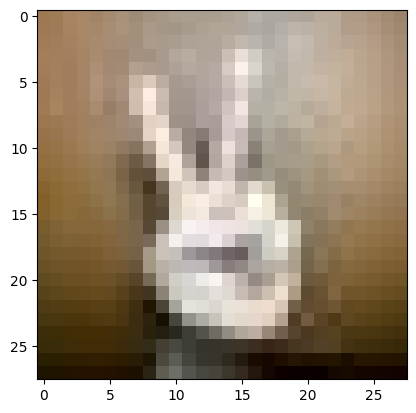

In [ ]:
# 변형된 데이터 불러와서 확인하기

import matplotlib.pyplot as plt

plt.imshow(x_train[0])
print('라벨: ', y_train[0])

# 딥러닝 네트워크 설계하기

In [ ]:
from tensorflow import keras

# 이미지 채널이 3개, 추론할 클래스도 3개 (MNIST와의 차이점)

# 모델 생성
model = keras.models.Sequential()

# 첫 번째 컨볼루션 층 추가
model.add(keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 3)))

# 첫 번째 맥스 풀링 층 추가
model.add(keras.layers.MaxPooling2D(2, 2))

# 두 번째 컨볼루션 층 추가
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))

# 두 번째 맥스 풀링 층 추가
model.add(keras.layers.MaxPooling2D(2, 2))

# 데이터 평탄화 층 추가
model.add(keras.layers.Flatten())

# 완전 연결 (Dense) 층 추가
model.add(keras.layers.Dense(64, activation='relu'))

# 출력 층 추가 (클래스가 3개임을 고려)
model.add(keras.layers.Dense(3, activation='softmax'))

# 모델 요약 출력
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                51264     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

## 딥러닝 네트워크 학습시키기

### 학습결과 해석

- 학습결과를 해석하는데 사용되는 지표는 아래 3가지 입니다.

---

- 학습 손실(Loss)
    - 학습데이터에 대한 모델의 예측값과 실제값의 차이를 나타내는 지표.
    - Loss가 감소할 수록 모델이 더 정확하게 학습하고 있음을 의미
    - Loss가 지속적으로 감소하지 않는다면, 모델 학습이 진전되지 않을 수 있음

- 학습 정확도(Accuracy)
    - 검증데이터로 확인한 학습데이터에 대한 모델의 정확도
    - Accuracy가 증가할수록 모델이 더 정확하게 학습되고 있음을 의미
    - Accuracy가 100%에 도달하면 모델이 학습데이터를 완벽하게 예측할 수 있음을 의미하지만, 현실적으로 불가능에 가까운 일로 오히려 과적합을 의심해 봐야 함
- 검증 손실(Validation Loss)
    - 검증 데이터에 대한 모델의 예측값과 실제값의 차이
    - 검증 손실이 감소할수록 모델이 더 '일반화' 되고 있음을 의미
    - 검증 손실이 계속 증가한다면, 모델이 과적합될 가능성이 있음
- 검증 정확도(Validation Accuracy)
    - 검증 데이터에 대한 모델의 예측 정확도를 나타내는 지표.
    - 검증 정확도가 증가할 수록 모델이 더 일반화 되고 있음을 의미
    - 검증 정확도와 학습 정확도의 큰 차이가 없다면, 모델이 적절히 일반화 되었을 가능성이 있음

---

- 이러한 내용을 바탕으로 history에 저장된 데이터를 활용해 학습 결과와 그에 대한 해석을 그래프와 문장으로 출력하는 함수를 만들어 보겠습니다.

In [ ]:
import koreanize_matplotlib

# 학습결과 시각화 함수
def plot_training_history(history):
    # 학습 과정 시각화
    fig, axs = plt.subplots(2)

    # 정확도 그래프
    axs[0].plot(history.history['accuracy'], label='훈련 정확도')
    axs[0].plot(history.history['val_accuracy'], label='검증 정확도')
    axs[0].set_ylabel('정확도')
    axs[0].legend(loc='lower right')
    axs[0].set_title('정확도')
    axs[0].axhline(y=1, color='r', linestyle='--')  # 정확도 1.00 부분에 붉은 점선 추가

    # 손실 그래프
    axs[1].plot(history.history['loss'], label='훈련 손실')
    axs[1].plot(history.history['val_loss'], label='검증 손실')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend(loc='upper right')
    axs[1].set_title('Loss')

    plt.tight_layout()
    plt.show()

In [ ]:
def analyze_model_performance(history):
    # 판단 결과와 근거를 담을 딕셔너리
    overfitting_criteria = {}

    # history 객체에서 데이터 추출
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # 최종 정확도 비교
    # 최종 epoch의 훈련 정확도가 검증 정확도보다 0.05 이상 높으면 과적합으로 판단
    accuracy_gap = train_acc[-1] - val_acc[-1]
    overfitting_criteria['accuracy_gap'] = {
        'result': accuracy_gap > 0.05,
        'reason': f"최종 epoch의 훈련 정확도가 검증 정확도보다 {accuracy_gap:.2f}만큼 높습니다.",
        'solution': "과적합을 줄이기 위해 모델의 복잡성을 줄이거나, 정규화 기법을 사용해보세요."
    }

    # 손실 추이 비교
    overfitting_criteria['loss_gap'] = {
        'result': False,
        'reason': '',
        'solution': "조기 종료(Early Stopping) 기법을 사용하여 검증 손실이 증가하면 학습을 중단해보세요."
    }

    overfitting_start_epoch = None

    for epoch in range(1, len(train_loss)):
        # 학습 손실이 감소하고 검증 손실도 감소하는 경우를 확인
        if train_loss[epoch] < train_loss[epoch - 1] and val_loss[epoch] < val_loss[epoch - 1]:
            continue
        # 검증 손실이 감소하다가 증가하는 경우를 감지
        elif val_loss[epoch] > val_loss[epoch - 1]:
            overfitting_criteria['loss_gap']['result'] = True
            overfitting_criteria['loss_gap']['reason'] = f"Epoch {epoch + 1} 이후 검증 손실이 증가하고 있습니다."
            overfitting_start_epoch = epoch + 1
            break

    # Epoch에 따른 정확도 변화
    # 검증 정확도가 최대값을 찍은 이후 감소하면 과적합으로 판단
    overfitting_criteria['accuracy_over_epochs'] = {
        'result': np.argmax(val_acc) < len(val_acc) - 1,
        'reason': f"검증 정확도가 Epoch {np.argmax(val_acc)+1} 이후로 감소하고 있습니다.",
        'solution': "학습률을 조절하거나, 학습률 스케줄링을 사용해보세요."
    }

    # Epoch에 따른 손실 변화
    # 검증 손실이 최소값을 찍은 이후 증가하면 과적합으로 판단
    overfitting_criteria['loss_over_epochs'] = {
        'result': np.argmin(val_loss) < len(val_loss) - 1,
        'reason': f"검증 손실이 Epoch {np.argmin(val_loss)+1} 이후로 증가하고 있습니다.",
        'solution': "드롭아웃이나 배치 정규화 등의 기법을 사용해보세요."
    }

    # 과적합 여부 최종 판단
    overfitting_detected = any(criteria['result'] for criteria in overfitting_criteria.values())

    # 결과 출력
    print(f"과적합 판단 결과: {'과적합의 의심됩니다.' if overfitting_detected else '과적합이 의심되지 않습니다.'}")
    print('그 이유는 아래와 같습니다.')
    print('-'*70)
    for criterion, result in overfitting_criteria.items():
        print(f"{criterion} 기준: {result['reason']} ({'과적합' if result['result'] else '정상'})")
        if result['result']:
            print(f"해결방안: {result['solution']}")
            print('-'*70)

    if overfitting_detected:
        print(f"  과적합이 시작되는 에포크는 대략 {overfitting_start_epoch}입니다.")
        if train_acc[-1] > 0.75 and val_acc[-1] < 0.75:
            print("  - 학습 정확도는 높지만 검증 정확도가 낮으므로 드롭아웃을 시도해 보세요.")
            print('-'*70)
        if max(train_loss) - min(train_loss) > 0.5:
            print("  - 학습 손실의 변동폭이 크니 가중치 규제를 추가해보세요.")
            print('-'*70)
        if overfitting_start_epoch is not None and overfitting_start_epoch < len(train_loss) * 0.75:
            print("  - 과적합이 비교적 일찍 시작되었으니 조기 종료를 시도해보세요.")
            print('-'*70)
        if train_loss[-1] > train_loss[0]:
            print("  - 학습률이 너무 높을 수 있습니다. 학습률을 줄여보세요.")
            print('-'*70)
        if (train_loss[-1] - min(train_loss)) > 0.1:
            print("  - 학습률이 너무 낮을 수 있습니다. 학습률을 늘려보세요.")
            print('-'*70)
    else:
        print("  과적합의 명확한 시작 지점을 찾을 수 없습니다. 모델이 잘 일반화되고 있는 것으로 보입니다.")
        print('-'*70)

    if train_loss[-1] > train_loss[0] and val_loss[-1] > val_loss[0]:
        print("  모델의 성능이 전반적으로 개선되지 않고 있습니다. 다음을 고려해보세요:")
        print("  - 현재 모델 구조가 데이터에 적합하지 않을 수 있습니다. 모델 구조 변경을 시도해 보세요.")
        print("  - 데이터 다양성 증가: 데이터셋의 다양성을 높이거나 데이터 양을 늘려보세요.")
    elif not overfitting_detected and (train_loss[-1] < train_loss[0] or val_loss[-1] < val_loss[0]):
        print("  모델이 적절히 학습되고 있는것 같습니다. 추가적인 성능 향상을 위해 다음을 고려해보세요:")
        print("  - 하이퍼파라미터 튜닝: 학습률, 배치 크기 등을 조정해보세요.")
        print("  - 추가 데이터 활용: 더 많은 데이터를 사용하여 모델을 학습시키세요.")

    print('-'*70)
    print('다만, 이는 학습데이터에 대한 검증 결과이므로 테스트 데이터에 모델을 적용해서 정확한 판단을 할 필요가 있습니다.')

Epoch 1/10
8/8 [==============================] - 4s 34ms/step - loss: 1.0244 - accuracy: 0.4792 - val_loss: 1.9790 - val_accuracy: 0.0000e+00
Epoch 2/10
8/8 [==============================] - 0s 6ms/step - loss: 0.8824 - accuracy: 0.8042 - val_loss: 1.7213 - val_accuracy: 0.0000e+00
Epoch 3/10
8/8 [==============================] - 0s 6ms/step - loss: 0.7472 - accuracy: 0.8292 - val_loss: 1.6987 - val_accuracy: 0.0000e+00
Epoch 4/10
8/8 [==============================] - 0s 6ms/step - loss: 0.5853 - accuracy: 0.8875 - val_loss: 1.6420 - val_accuracy: 0.0000e+00
Epoch 5/10
8/8 [==============================] - 0s 6ms/step - loss: 0.4424 - accuracy: 0.8875 - val_loss: 1.9101 - val_accuracy: 0.0000e+00
Epoch 6/10
8/8 [==============================] - 0s 5ms/step - loss: 0.3073 - accuracy: 0.9375 - val_loss: 1.3260 - val_accuracy: 0.0000e+00
Epoch 7/10
8/8 [==============================] - 0s 6ms/step - loss: 0.1843 - accuracy: 0.9500 - val_loss: 0.8354 - val_accuracy: 0.4500
Epoch 8/1

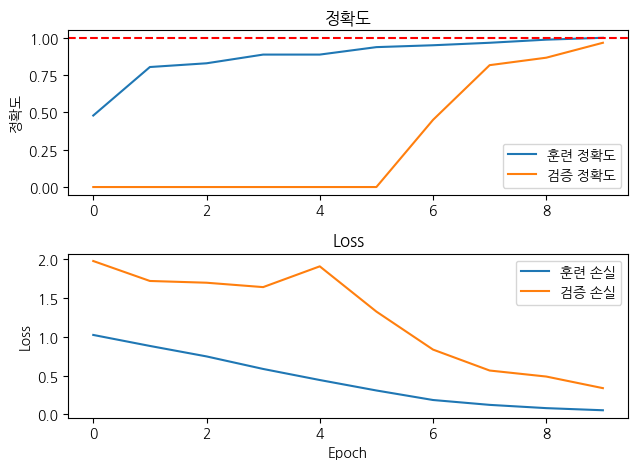

과적합 판단 결과: 과적합의 의심됩니다.
그 이유는 아래와 같습니다.
----------------------------------------------------------------------
accuracy_gap 기준: 최종 epoch의 훈련 정확도가 검증 정확도보다 0.03만큼 높습니다. (정상)
loss_gap 기준: Epoch 5 이후 검증 손실이 증가하고 있습니다. (과적합)
해결방안: 조기 종료(Early Stopping) 기법을 사용하여 검증 손실이 증가하면 학습을 중단해보세요.
----------------------------------------------------------------------
accuracy_over_epochs 기준: 검증 정확도가 Epoch 10 이후로 감소하고 있습니다. (정상)
loss_over_epochs 기준: 검증 손실이 Epoch 10 이후로 증가하고 있습니다. (정상)
  과적합이 시작되는 에포크는 대략 5입니다.
  - 학습 손실의 변동폭이 크니 가중치 규제를 추가해보세요.
----------------------------------------------------------------------
  - 과적합이 비교적 일찍 시작되었으니 조기 종료를 시도해보세요.
----------------------------------------------------------------------
----------------------------------------------------------------------
다만, 이는 학습데이터에 대한 검증 결과이므로 테스트 데이터에 모델을 적용해서 정확한 판단을 할 필요가 있습니다.


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 학습 (validation 데이터를 20%로 설정해서 모델성능 테스트)
# 정규화된 데이터입력
history = model.fit(x_train, y_train, epochs=10, validation_split=0.2)

# 모델 학습 결과 확인
plot_training_history(history)
analyze_model_performance(history)

# 학습결과 테스트하기

## 테스트데이터 불러오기 및 생성

- 같은 퀘스트를 진행하는 동료그루들이 생성한 데이터를 공유받아 테스트용 데이터로 사용했습니다.
- 학습데이터와 동일하게 rock, scissor, paper 각각 100장씩 총 300장의 데이터를 사용했습니다.

### 테스트 데이터 압축풀기

In [ ]:
# 테스트 데이터 폴더의 데이터 unzip하기
base_path = '../data/rock_scissor_paper/test'
unzip_files(base_path)

scissor 압축 해제 완료
rock 압축 해제 완료
paper 압축 해제 완료


### 테스트 데이터 resize로 크기 일괄 조정하기
- 학습 데이터와 같은 사이즈인 (28,28) 형태로 테스트 데이터도 사이즈 조정을 해줍니다.
- 동료 그루분들이 이미 (28,28)사이즈로 resize 된 데이터를 사용하는 경우도 있어 변경이 되지 않을 수도 있습니다.

In [ ]:
# 작업 경로
image_dir_paths = [
    "../data/rock_scissor_paper/test/scissor",
    "../data/rock_scissor_paper/test/rock",
    "../data/rock_scissor_paper/test/paper"
]

# 각 폴더별로 이미지 불러와서 resize 작업 수행
for path in image_dir_paths:
    resize_images(path, 28, 28)
    if path.endswith("/scissor"):
        print("-" * 30)
        print("테스트 데이터의 가위 이미지 resize 완료!")
        print("-" * 30)
    elif path.endswith("/rock"):
        print("-" * 30)
        print("테스트 데이터의 바위 이미지 resize 완료!")
        print("-" * 30)
    elif path.endswith("/paper"):
        print("-" * 30)
        print("테스트 데이터의 보자기 이미지 resize 완료!")
        print("-" * 30)

100 개의 이미지가 resize될 예정입니다.
100 개의 이미지가 resize되었습니다.
이미 size가 (28, 28) 인 데이터 0 개는 변형하지 않고 skip했습니다.
------------------------------
테스트 데이터의 가위 이미지 resize 완료!
------------------------------
100 개의 이미지가 resize될 예정입니다.
100 개의 이미지가 resize되었습니다.
이미 size가 (28, 28) 인 데이터 0 개는 변형하지 않고 skip했습니다.
------------------------------
테스트 데이터의 바위 이미지 resize 완료!
------------------------------
100 개의 이미지가 resize될 예정입니다.
100 개의 이미지가 resize되었습니다.
이미 size가 (28, 28) 인 데이터 0 개는 변형하지 않고 skip했습니다.
------------------------------
테스트 데이터의 보자기 이미지 resize 완료!
------------------------------


In [ ]:
# 테스트 데이터 세트 로드
image_dir_path = "../data/rock_scissor_paper/test"
(x_test, y_test) = load_data(image_dir_path, 300, dataset_type="테스트")
x_test = x_test[:300]

x_test = x_test / 255.0 # 입력은 0~1 사이의 값으로 정규화

print("x_test의 형태: {}".format(x_test.shape))
print("y_test의 형태: {}".format(y_test.shape))

테스트 데이터의 로드된 이미지 수:  300
x_test의 형태: (300, 28, 28, 3)
y_test의 형태: (300,)


## 테스트 결과 확인

In [ ]:
# x_test_reshaped는 테스트 데이터이고, y_test는 데이터의 실제 레이블입니다
# verbose=2는 평가 과정을 자세히 표시합니다
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)

# 테스트 손실(test_loss)과 테스트 정확도(test_accuracy)를 출력합니다
print(f"테스트 손실: {test_loss}")
print(f"테스트 정확도: {test_accuracy}")

10/10 - 0s - loss: 1.7885 - accuracy: 0.3367
테스트 손실: 1.7884653806686401
테스트 정확도: 0.33666667342185974


### 테스트 결과 해석

- 학습 당시에 모델 정확도가 높고 일반화되었던 것에 비해 테스트의 결과는 매우 하락해 있습니다.
- 위에 학습결과에서 우려했던것처럼 과적합된 모델인 것이 맞는 것 같습니다.
- 일단 모델이 어떤 추론을 했는지 확인해 보겠습니다.

## 잘못 추론한 데이터 확인하기

- 먼저 결과 확인을 위한 시각화 함수를 작성하겠습니다.
    - 학습된 모델과 테스트데이터를 이용해 정답을 맞춘 경우와 그렇지 못한 경우에 대한 결과를 시각화 합니다.

In [ ]:
import random
import koreanize_matplotlib

def visualize_model_predictions(model, x_test, y_test, num_samples=6, correct_predictions=True):
    """
    모델의 예측 결과를 시각화하는 함수
    매개변수:
    - model: 학습된 모델 객체
    - x_test: 테스트 데이터셋
    - y_test: 테스트 데이터셋의 실제 레이블
    - num_samples: 시각화할 샘플의 개수
    - correct_predictions: True일 경우 정답을 맞춘 케이스를, False일 경우 잘못 예측한 케이스를 시각화
    """
    # 모델을 사용하여 테스트 데이터에 대한 예측을 수행
    predicted_result = model.predict(x_test)

    # 각 테스트 데이터에 대한 예측된 클래스 레이블을 계산
    predicted_labels = np.argmax(predicted_result, axis=1)

    # 정답을 맞춘 경우 또는 잘못 예측된 경우의 인덱스 찾기
    if correct_predictions:
        indices = np.where(predicted_labels == y_test)[0]
    else:
        indices = np.where(predicted_labels != y_test)[0]

    # 시각화할 샘플의 인덱스를 무작위로 선택
    sample_indices = random.choices(population=indices, k=num_samples)

    # 시각화를 위한 2행 3열의 서브플롯을 생성
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    for i, idx in enumerate(sample_indices):
        row = i // 3
        col = i % 3

        # 모델이 예측한 확률 분포를 사용
        predicted_probabilities = predicted_result[idx]

        # 실제 레이블에 해당하는 확률값을 추출
        probability = predicted_probabilities[predicted_labels[idx]] * 100

        # 각 서브플롯에 실제 레이블, 모델의 예측, 그리고 확률값을 출력
        label_and_prediction = "실제 레이블: {}, 모델 예측: {}, 확률: {:.2f}%".format(
            y_test[idx], predicted_labels[idx], probability)

        # 이미지와 예측 결과를 서브플롯에 표시
        axes[row, col].imshow(x_test[idx], cmap=plt.cm.binary)
        axes[row, col].set_title(label_and_prediction)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

### 모델이 올바르게 추정한 데이터의 확률 살펴보기

- 출력정보는 아래와 같습니다.
    - 실제 레이블 : test 데이터가 가진 실제 레이블 값
    - 모델 예측 : 모델이 test 데이터에 대해 predcit한 레이블 값
    - 확률 : 모델이 test 데이터에 대해 predict할때 해당 레이블이라고 몇%의 확률로 예측했는지에 대한 값

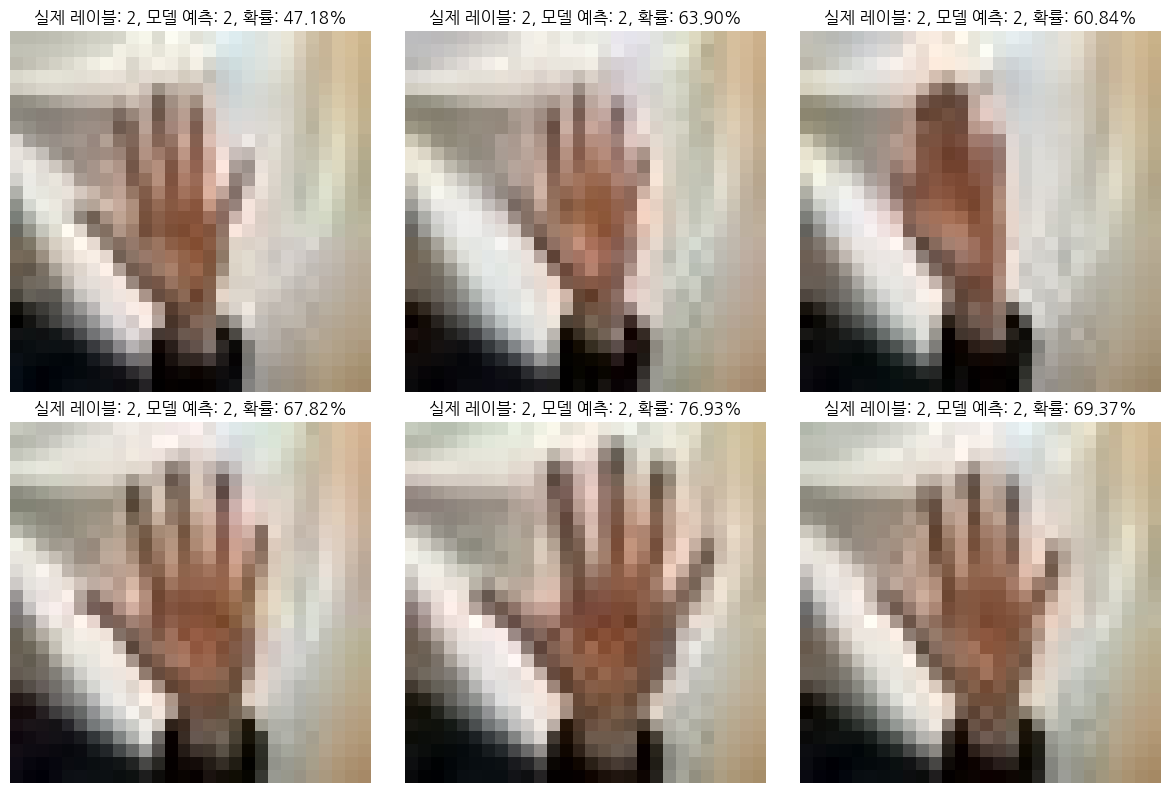

In [ ]:
# 정답을 맞춘 경우 시각화
visualize_model_predictions(model, x_test, y_test, num_samples=6, correct_predictions=True)

### 모델이 잘못 추정한 데이터의 확률 살펴보기

- 출력정보는 아래와 같습니다.
    - 실제 레이블 : test 데이터가 가진 실제 레이블 값
    - 모델 예측 : 모델이 test 데이터에 대해 predcit한 레이블 값
    - 확률 : 모델이 test 데이터에 대해 predict할때 해당 레이블이라고 몇%의 확률로 예측했는지에 대한 값

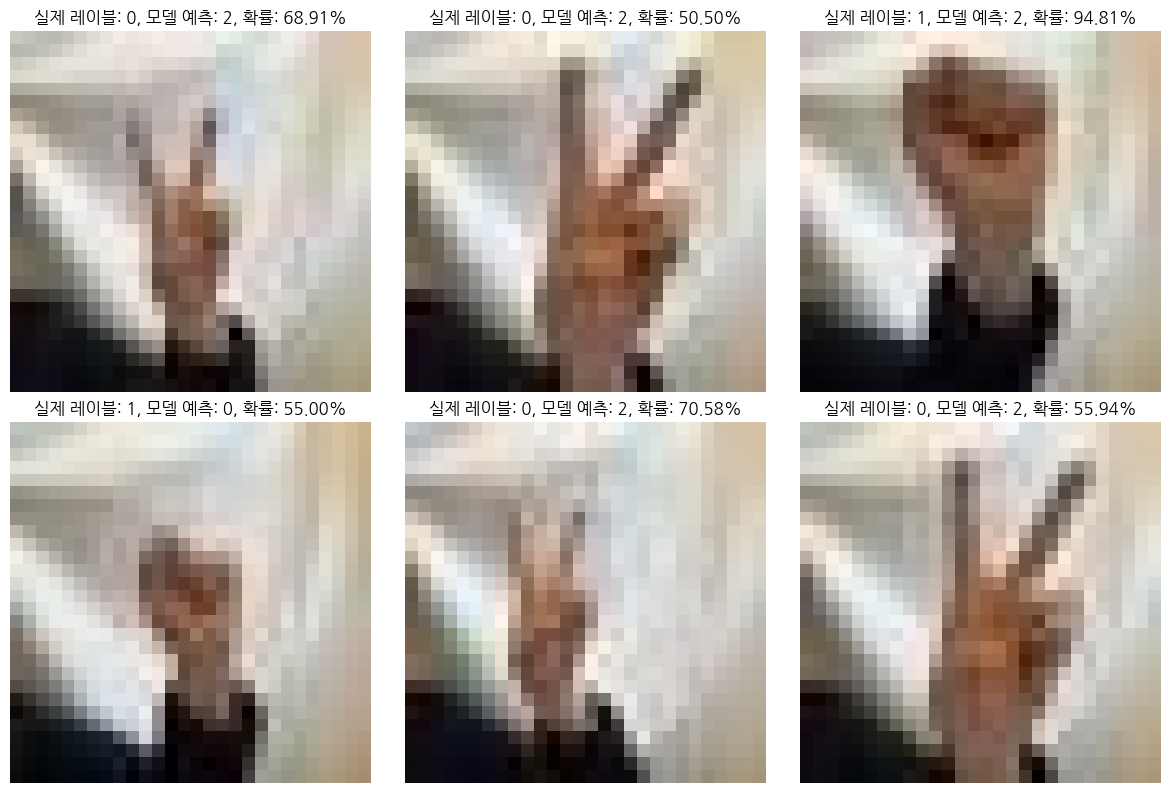

In [ ]:
# 잘못 예측된 경우 시각화
visualize_model_predictions(model, x_test, y_test, num_samples=6, correct_predictions=False)

- 정답인 경우에도 높은 확률로 확신하고 있고, 오답을 내는 경우에도 매우 높은 확률로 모델이 정답이라 확신하고 있습니다.
- 여러 이유가 있을 수 있으나 가장 먼저 걱정이 되는것은 학습데이터와 테스트 데이터의 특징이 다를 수 있다는 점입니다.

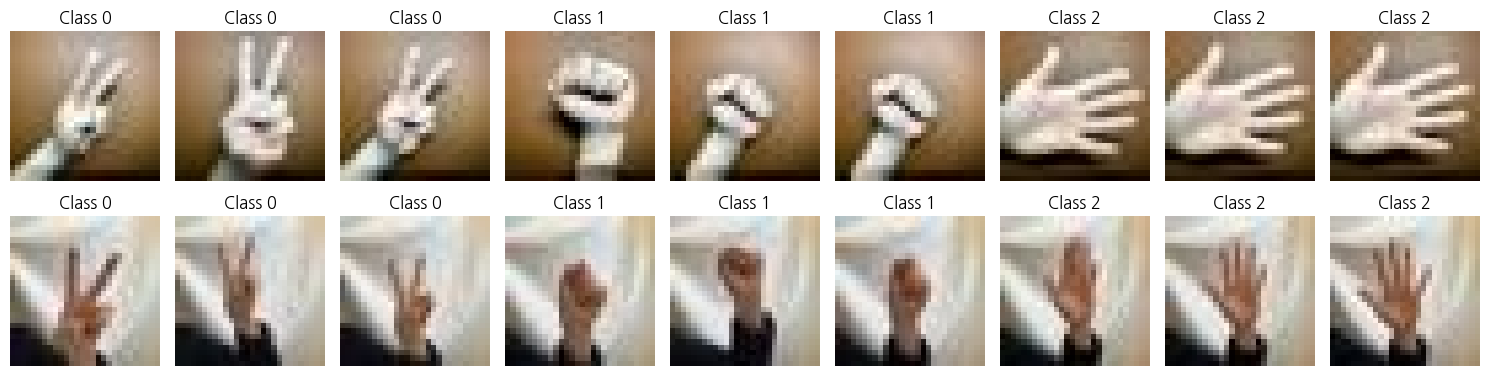

In [ ]:
# 클래스별로 데이터 인덱스를 추출하는 함수
def extract_class_samples(x, y, num_classes):
    class_indices = {}
    for class_idx in range(num_classes):
        class_indices[class_idx] = [i for i, label in enumerate(y) if label == class_idx]
    return class_indices

# 각 클래스별 여러 개의 샘플을 무작위로 선택하는 함수 (샘플 수를 num_samples로 지정)
def choose_random_samples(class_indices, num_classes, num_samples=3):
    sample_indices = []
    for class_idx in range(num_classes):
        sample_indices.extend(random.sample(class_indices[class_idx], num_samples))
    return sample_indices

# 학습 및 테스트 데이터에서 클래스별로 샘플 선택
num_classes = len(np.unique(y_train))  # 클래스의 개수를 결정
train_class_indices = extract_class_samples(x_train, y_train, num_classes)
test_class_indices = extract_class_samples(x_test, y_test, num_classes)

# 무작위로 학습 및 테스트 샘플 선택 (각 클래스별로 3개씩)
train_samples = choose_random_samples(train_class_indices, num_classes, num_samples=3)
test_samples = choose_random_samples(test_class_indices, num_classes, num_samples=3)

# 시각화
fig, axes = plt.subplots(2, num_classes * 3, figsize=(15, 4))  # 3배 넓은 서브플롯 생성

for i, idx in enumerate(train_samples):
    axes[0, i].imshow(x_train[idx], cmap=plt.cm.binary)
    axes[0, i].set_title(f'Class {y_train[idx]}')
    axes[0, i].axis('off')

for i, idx in enumerate(test_samples):
    axes[1, i].imshow(x_test[idx], cmap=plt.cm.binary)
    axes[1, i].set_title(f'Class {y_test[idx]}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

### 잘못된 추정에 대한 원인 추정

- 학습데이터의 경우 주황색 배경이라 손의 특징이 명확하게 추출되지 않을 수도 있을 것 같습니다.
- 테스트 데이터의 경우 손뿐만 아니라 팔이 포함되어 있어 모델이 학습한 손모양만 있는 데이터와 달라 특징을 파악하지 못할 수 도 있을 것 같습니다.
- 일단, 학습데이터를 늘려서 재학습을 시도해보겠습니다.

# 모델 성능 개선하기

- 모델 성능 개선을 위해 사용할 수 있는 방법이 다양하게 있음을 공부하며 배웠습니다.
- 이번 과정에서는 **모델 성능의 획기적인 향상보다는 공부했던 다양한 기법들을 최대한 적용해보는 것을 목표**로 모델 성능 개선을 시도하겠습니다.
- 시도할 모델 성능 개선 방법은 아래와 같습니다.

1. 학습데이터 추가
2. 학습률 조정
3. 드롭아웃
4. 학습률 조정
5. 데이터 증강(Data Augmentation)
6. 베이지안 최적화(Baysian Optimization)

---

## 1. 학습 데이터 추가

- 추가적인 학습데이터는 같은 기수에 학습하고 있는 그루분들이 생성한 데이터를 활용하도록 하겠습니다.
- 유사한 task를 수행한 문서를 찾아보니 약 730여개의 이미지를 활용한 것을 확인했습니다.[(참고문헌)](https://medium.com/geekculture/rock-paper-scissors-image-classification-using-cnn-eefe4569b415)
    - 데이터셋의 구성만 참고했고, 내용을 보진 않았습니다. (퀘스트 종료후에 살펴볼 예정입니다.)
- 이를 고려해 동료 그루들이 생성한 데이터 4648개를 추가해 총 4948개의 데이터로 모델을 재학습 하겠습니다

---

- 추가데이터는 구글드라이브에서 다운받아 로컬 폴더에 입력하는데 처리해야할 문제가 여러개 있습니다.
    - 1. 모두 zip파일로 구성되어 있습니다.
    - 2. upzip을 하면, 모든 파일명들이 rock, scissor, paper라는 폴더 안에 `0.jpg~99.jpg` 와 같이 폴더로만 데이터가 구분되고 파일명에선 구분이 되지 않습니다.
    - 3. unzip을 할 경우 동일한 파일명에 대해 `0(1).jpg`, `0(2).jpg` 와 같은 식으로 파일명이 생성되거나, 덮어쓰기가 될 수 있습니다.
    
- 따라서, 이를 정리하기위한 코드를 생성해 사용하겠습니다.

In [ ]:
# 압축 파일이 있는 기본 폴더 경로 설정
base_folder = '../data/rock_scissor_paper'

# 추가 데이터 폴더들
additional_folders = ['additional_1', 'additional_2', 'additional_3', 'additional_4',
                      'additional_5', 'additional_6', 'additional_7', 'additional_8',
                      'additional_9', 'additional_10', 'additional_11', 'additional_12', 'additional_13']

# 주어진 unzip_files 함수를 각 추가 폴더에 대해 실행
for additional_folder in additional_folders:
    # 각 추가 폴더의 전체 경로 설정
    additional_folder_path = os.path.join(base_folder, additional_folder)

    print(f'{additional_folder} 폴더의 작업 시작')
    # unzip_files 함수 호출
    unzip_files(additional_folder_path)
    print('-'*70)

# 함수 호출 완료 메시지 출력
print("모든 압축 해제 작업 완료")

additional_1 폴더의 작업 시작
scissor 압축 해제 완료
rock 압축 해제 완료
paper 압축 해제 완료
----------------------------------------------------------------------
additional_2 폴더의 작업 시작
scissor 압축 해제 완료
rock 압축 해제 완료
paper 압축 해제 완료
----------------------------------------------------------------------
additional_3 폴더의 작업 시작
scissor 압축 해제 완료
rock 압축 해제 완료
paper 압축 해제 완료
----------------------------------------------------------------------
additional_4 폴더의 작업 시작
scissor 압축 해제 완료
rock 압축 해제 완료
paper 압축 해제 완료
----------------------------------------------------------------------
additional_5 폴더의 작업 시작
scissor 압축 해제 완료
rock 압축 해제 완료
paper 압축 해제 완료
----------------------------------------------------------------------
additional_6 폴더의 작업 시작
scissor 압축 해제 완료
rock 압축 해제 완료
paper 압축 해제 완료
----------------------------------------------------------------------
additional_7 폴더의 작업 시작
scissor 압축 해제 완료
rock 압축 해제 완료
paper 압축 해제 완료
----------------------------------------------------------------------
additional_8 폴더의 작업 

In [ ]:
# 추가할 폴더의 데이터에 있는 이미지명을 기존 학습 데이터 폴더의 파일명과 비교해 변경하고 이동시키는 함수
def rename_and_move_files(folders_dict):
    for category in ['rock', 'scissor', 'paper']:
        src_folder = os.path.join(folders_dict['src'], category)
        dest_folder = os.path.join(folders_dict['dest'], category)

        # 1번째 폴더에서 가장 큰 숫자 찾기
        max_num = 0
        for file in os.listdir(src_folder):
            if file.endswith('.jpg'):
                num = int(file.split('.')[0])
                max_num = max(max_num, num)

        # 2번째 폴더의 파일 이름 변경 및 이동
        next_num = max_num + 1
        completed = True  # 폴더별로 완료 여부를 추적하기 위한 변수

        for file in os.listdir(dest_folder):
            if file.endswith('.jpg'):
                old_name = file
                new_name = f"{next_num}.jpg"
                new_path = os.path.join(src_folder, new_name)
                old_path = os.path.join(dest_folder, old_name)

                try:
                    # 파일 이름 변경
                    os.rename(old_path, new_path)
                    #print(f"{old_name}을(를) {new_name}로 변경 및 이동")
                except Exception as e:
                    print(f"오류 발생: {e}")
                    completed = False  # 오류 발생 시 완료 여부를 False로 설정

                next_num += 1

        if completed:
            print(f"{dest_folder} 폴더의 파일 이름 변경 및 이동이 완료되었습니다.")

In [ ]:
# 반복할 폴더 목록을 만듭니다.
src_folder = '../data/rock_scissor_paper/'
dest_folders = ['additional_1', 'additional_2', 'additional_3', 'additional_4',
                      'additional_5', 'additional_6', 'additional_7', 'additional_8',
                      'additional_9', 'additional_10', 'additional_11', 'additional_12', 'additional_13']

# 각 dest 폴더에 대해 작업을 수행하는 반복문을 만듭니다.
for dest_folder_name in dest_folders:
    # 슬래시로 경로를 지정합니다.
    dest_path = os.path.join(src_folder, dest_folder_name)

    # 실제로 파일을 이동하거나 작업을 수행하는 함수 호출
    folders_dict = {'src': src_folder, 'dest': dest_path}
    rename_and_move_files(folders_dict)

../data/rock_scissor_paper/additional_1\rock 폴더의 파일 이름 변경 및 이동이 완료되었습니다.
../data/rock_scissor_paper/additional_1\scissor 폴더의 파일 이름 변경 및 이동이 완료되었습니다.
../data/rock_scissor_paper/additional_1\paper 폴더의 파일 이름 변경 및 이동이 완료되었습니다.
../data/rock_scissor_paper/additional_2\rock 폴더의 파일 이름 변경 및 이동이 완료되었습니다.
../data/rock_scissor_paper/additional_2\scissor 폴더의 파일 이름 변경 및 이동이 완료되었습니다.
../data/rock_scissor_paper/additional_2\paper 폴더의 파일 이름 변경 및 이동이 완료되었습니다.
../data/rock_scissor_paper/additional_3\rock 폴더의 파일 이름 변경 및 이동이 완료되었습니다.
../data/rock_scissor_paper/additional_3\scissor 폴더의 파일 이름 변경 및 이동이 완료되었습니다.
../data/rock_scissor_paper/additional_3\paper 폴더의 파일 이름 변경 및 이동이 완료되었습니다.
../data/rock_scissor_paper/additional_4\rock 폴더의 파일 이름 변경 및 이동이 완료되었습니다.
../data/rock_scissor_paper/additional_4\scissor 폴더의 파일 이름 변경 및 이동이 완료되었습니다.
../data/rock_scissor_paper/additional_4\paper 폴더의 파일 이름 변경 및 이동이 완료되었습니다.
../data/rock_scissor_paper/additional_5\rock 폴더의 파일 이름 변경 및 이동이 완료되었습니다.
../data/rock_scissor_paper/addition

### 이미지 리사이징

In [ ]:
# 작업 경로
image_dir_paths = [
    "../data/rock_scissor_paper/scissor",
    "../data/rock_scissor_paper/rock",
    "../data/rock_scissor_paper/paper"
]

# 각 폴더별로 이미지 불러와서 resize 작업 수행
for path in image_dir_paths:
    resize_images(path, 28,28)
    if path.endswith("/scissor"):
        print("-" * 30)
        print("가위 이미지 resize 완료!")
        print("-" * 30)
    elif path.endswith("/rock"):
        print("-" * 30)
        print("바위 이미지 resize 완료!")
        print("-" * 30)
    elif path.endswith("/paper"):
        print("-" * 30)
        print("보자기 이미지 resize 완료!")
        print("-" * 30)

2524 개의 이미지가 resize될 예정입니다.
2324 개의 이미지가 resize되었습니다.
이미 size가 (28, 28) 인 데이터 200 개는 변형하지 않고 skip했습니다.
------------------------------
가위 이미지 resize 완료!
------------------------------
2521 개의 이미지가 resize될 예정입니다.
2321 개의 이미지가 resize되었습니다.
이미 size가 (28, 28) 인 데이터 200 개는 변형하지 않고 skip했습니다.
------------------------------
바위 이미지 resize 완료!
------------------------------
2635 개의 이미지가 resize될 예정입니다.
2435 개의 이미지가 resize되었습니다.
이미 size가 (28, 28) 인 데이터 200 개는 변형하지 않고 skip했습니다.
------------------------------
보 이미지 resize 완료!
------------------------------


### 학습용 데이터 재생성

In [ ]:
# 학습 데이터 세트 로드
# 이미지 디렉토리 경로 설정
image_dir_path = "../data/rock_scissor_paper"

# rock, paper, scissor 폴더의 파일 수 확인
rock_dir = os.path.join(image_dir_path, "rock")
paper_dir = os.path.join(image_dir_path, "paper")
scissor_dir = os.path.join(image_dir_path, "scissor")

num_rock_images = len(os.listdir(rock_dir))
num_paper_images = len(os.listdir(paper_dir))
num_scissor_images = len(os.listdir(scissor_dir))


# 가장 파일 수가 적은 폴더의 수로 num_images 매개변수값 설정
# 클래스별 데이터의 개수를 맞춰주기 위함
num_images = min(num_rock_images, num_paper_images, num_scissor_images)
total_number_of_data = (num_images * 3)

# labels 배열의 크기를 total_number_of_data로 초기화
labels = np.zeros(total_number_of_data, dtype=np.int32)

(x_train, y_train) = load_data(image_dir_path, number_of_data=total_number_of_data, dataset_type="학습")
x_train = x_train[:total_number_of_data]

x_train = x_train / 255.0  # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습 데이터의 로드된 이미지 수:  7566
x_train shape: (7566, 28, 28, 3)
y_train shape: (7566,)


라벨:  0


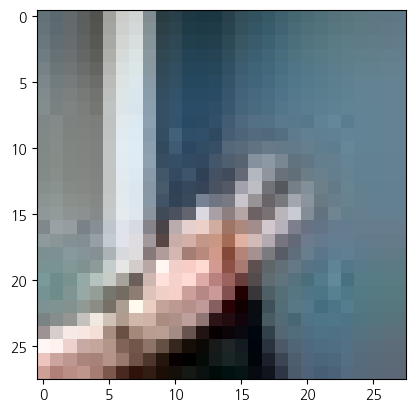

In [ ]:
# 변형된 데이터 불러와서 확인하기

import matplotlib.pyplot as plt

plt.imshow(x_train[800])
print('라벨: ', y_train[800])

### 모델 재학습 및 테스트(교차검증)

- 이번에는 테스트시에 교차검증(Cross-validation)을 수행할 것입니다.
- 여기서는 이미지 분류기에서 가장 흔하게 사용되는 StratifiedKFold 방식을 사용하겠습니다.
- StratifiedKFold는 각 클래스의 샘플 비율이 전체 데이터셋에서와 유사하게 유지되도록 폴드를 구성하기 때문에 클래스별 데이터가 균등한 것이 중요한 이미지 분류에 유용합니다.

---

- [참고 1: Kreas로 K-fold cross validation 하기](https://blog.naver.com/nywoo19/221970913783)
- [참고 2: [개발팁] 'MultilabelStrarifiedKFold' : Multi-label classification 에 적용 가능한 strarification cross validator](https://cvml.tistory.com/25)
- [참고 3: 층화 샘플링 (StratifiedKFold) -- 데이터 분리 (kfold stratify) - 기존 검증 방법](https://wikidocs.net/43286)

In [ ]:
from sklearn.model_selection import StratifiedKFold

# 모델을 생성하는 함수 정의
def create_model():
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 3)))
    model.add(keras.layers.MaxPooling2D(2, 2))
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D(2, 2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(3, activation='softmax'))

    # 컴파일
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# StratifiedKFold 설정
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 각 폴드에 대한 점수를 저장할 리스트
scores = []

# 교차 검증
fold_num = 1
for train_index, test_index in skf.split(x_train, y_train):
    # 데이터 분할
    x_train_fold, x_test_fold = x_train[train_index], x_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    # 모델 생성 및 훈련
    model = create_model()
    model.fit(x_train_fold, y_train_fold, epochs=10, batch_size=10, verbose=0)

    # 평가
    score = model.evaluate(x_test_fold, y_test_fold, verbose=0)
    scores.append(score)

    # 각 폴드의 점수 출력
    print(f"Fold {fold_num}: Loss = {score[0]}, Accuracy = {score[1]}")
    fold_num += 1

# 평균 성능 계산
avg_score = np.mean([score[1] for score in scores])  # 여기서 score[1]은 정확도를 의미합니다.
print(f"교차 검증 평균 정확도: {avg_score}")

Fold 1: Loss = 0.016994481906294823, Accuracy = 0.9927344918251038
Fold 2: Loss = 0.006162303499877453, Accuracy = 0.9980171918869019
Fold 3: Loss = 0.007827739231288433, Accuracy = 0.9986781477928162
Fold 4: Loss = 0.05386197566986084, Accuracy = 0.9788499474525452
Fold 5: Loss = 0.04128742590546608, Accuracy = 0.9834765195846558
교차 검증 평균 정확도: 0.9903512597084045


- 교차 검증 결과를 보면 학습 성능이 매우 향상된 것을 볼 수 있으며, Loss값도 낮은편으로 데이터가 모델에 잘 적합되었음을 의미합니다.
- 이제 테스트데이터에 모델을 적용해 실제 성능을 확인해 보겠습니다.
- 유의할점은 교차검증을 한 모델을 그대로 사용할 경우 최종학습한 Fold 5에 대한 데이터만 학습한 모델에 대해 테스트 하는 것으로, 전체 데이터를 모델에 재학습 시킨 후 평가를 해야 한다는 점 입니다.
    - 물론 분할하여 학습한 모델중 Best 모델을 사용하는 것도 방법이겠지만, 다양한 특성을 학습시키기 위해 데이터수를 늘린것이므로 특정 데이터가 아닌 전체 데이터를 학습시킨 모델을 사용하는게 더 좋을 것 같습니다.

### 테스트 결과 확인

In [ ]:
# 전체 훈련 데이터셋으로 모델 재학습
model = create_model()
model.fit(x_train, y_train, epochs=10, batch_size=10, verbose=0)

# 테스트 데이터셋으로 모델 평가
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)

# 테스트 손실과 테스트 정확도 출력
print(f"테스트 손실: {test_loss}")
print(f"테스트 정확도: {test_accuracy}")

10/10 - 0s - loss: 0.0021 - accuracy: 1.0000
테스트 손실: 0.0021141376346349716
테스트 정확도: 1.0


- 교차검증에서 모델의 일반화 성능도 검증이되었고, 테스트 결과도 정확도 100%로 매우 좋은 결과를 보여주고 있습니다.
- 이는 데이터의 증가로 인해 모델의 학습이 잘 이뤄진 증거라 할 수 있습니다.
- 하지만 성능이 너무 잘 나와서 학습이 잘못된건 아닐까 하는 의구심이 드는 것도 사실입니다.
- 학습데이터는 각 클래스별로 약 2500개인데 반해 테스트 데이터는 100개로 너무 볼륨의 차이가 나는 것 같습니다.
- 테스트 데이터를 포함해 전체 데이터를 하나로 합치고 train/test split으로 데이터를 분리한 후 모델을 재학습 시켜 보겠습니다.

## 데이터 비율 재분배

### 데이터 병합 (전체 학습 데이터 + 테스트 데이터)

In [ ]:
from sklearn.model_selection import train_test_split

# x_train, x_test, y_train, y_test를 각각 합칩니다.
x = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# 합친 데이터를 다시 학습 데이터와 테스트 데이터로 나눕니다.
# 이때, test_size 매개변수를 통해 테스트 데이터의 비율을 지정할 수 있습니다.
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

### 모델 재학습 및 테스트(교차검증)

In [ ]:
# StratifiedKFold 설정
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 각 폴드에 대한 점수를 저장할 리스트
scores = []

# 교차 검증
fold_num = 1
for train_index, test_index in skf.split(x_train_new, y_train_new):
    # 데이터 분할
    x_train_new_fold, x_test_fold = x_train_new[train_index], x_train_new[test_index]
    y_train_new_fold, y_test_fold = y_train_new[train_index], y_train_new[test_index]

    # 모델 생성 및 훈련
    model = create_model()
    model.fit(x_train_new_fold, y_train_new_fold, epochs=10, batch_size=10, verbose=0)

    # 평가
    score = model.evaluate(x_test_fold, y_test_fold, verbose=0)
    scores.append(score)

    # 각 폴드의 점수 출력
    print(f"Fold {fold_num}: Loss = {score[0]}, Accuracy = {score[1]}")
    fold_num += 1

# 평균 성능 계산
avg_score = np.mean([score[1] for score in scores])  # 여기서 score[1]은 정확도를 의미합니다.
print(f"교차 검증 평균 정확도: {avg_score}")

Fold 1: Loss = 0.029854072257876396, Accuracy = 0.9912629127502441
Fold 2: Loss = 0.015535105019807816, Accuracy = 0.9960286021232605
Fold 3: Loss = 0.0721864104270935, Accuracy = 0.975357711315155
Fold 4: Loss = 0.01921830326318741, Accuracy = 0.995230495929718
Fold 5: Loss = 0.02209405042231083, Accuracy = 0.9936407208442688
교차 검증 평균 정확도: 0.9903040885925293


### 테스트 결과 확인

In [ ]:
# 전체 훈련 데이터셋으로 모델 재학습
model = create_model()
model.fit(x_train_new, y_train_new, epochs=10, batch_size=10, verbose=0)

# 테스트 데이터셋으로 모델 평가
test_loss, test_accuracy = model.evaluate(x_test_new, y_test_new, verbose=2)

# 테스트 손실과 테스트 정확도 출력
print(f"테스트 손실: {test_loss}")
print(f"테스트 정확도: {test_accuracy}")

50/50 - 0s - loss: 0.0223 - accuracy: 0.9930
테스트 손실: 0.022266535088419914
테스트 정확도: 0.9930114150047302


### 모델이 올바르게 추정한 데이터의 확률 살펴보기

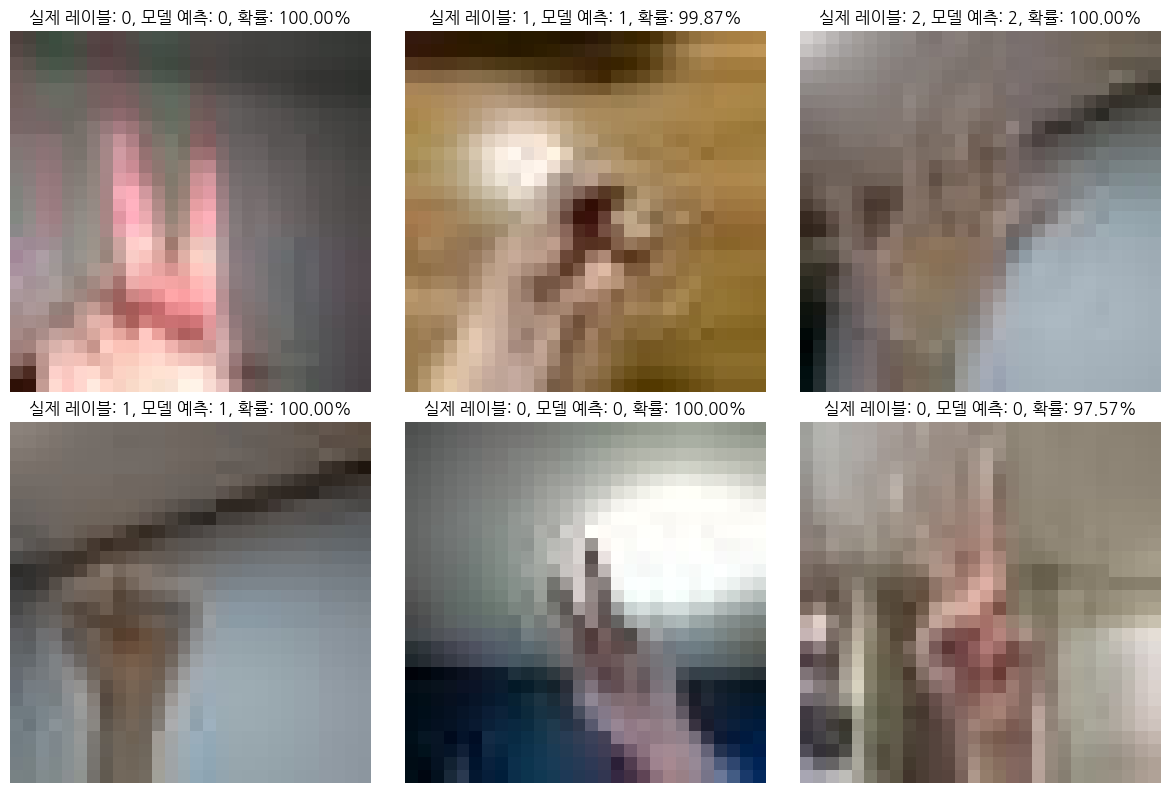

In [ ]:
# 정답을 맞춘 경우 시각화
visualize_model_predictions(model, x_test_new, y_test_new, num_samples=6, correct_predictions=True)

### 모델이 잘못 추정한 데이터의 확률 살펴보기

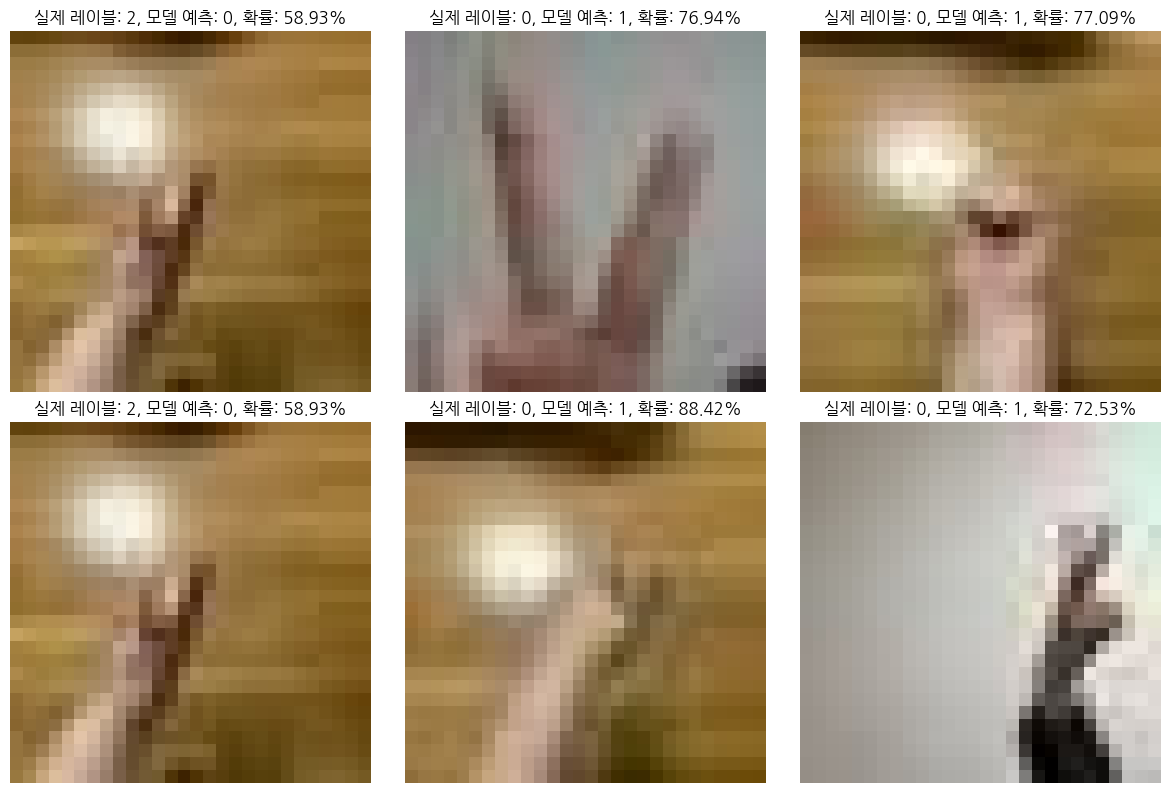

In [ ]:
# 잘못 예측된 경우 시각화
visualize_model_predictions(model, x_test_new, y_test_new, num_samples=6, correct_predictions=False)

---

### 결과 평가

- 교차 검증 결과:
    - 교차 검증을 통한 평균 정확도가 약 99.08%로 매우 높습니다.
    - 각 Fold의 정확도가 비교적 일관되게 높게 나타나고 있습니다.
    - 이는 모델이 다양한 데이터 셋에 대해 일관된 성능을 보여주고 있음을 나타냅니다.

- 독립적 테스트 데이터에 대한 결과:
    - 테스트 데이터에 대한 정확도가 약 98.73%로, 교차 검증 결과와 유사한 수준입니다.
    - 테스트 데이터의 손실(Loss)도 0.0384로 낮게 나타나고 있습니다.
    
- 종합적으로 모델이 일반화가 잘 되어 있고, 새로운 데이터에 대해서도 높은 성능을 유지하는 것 같습니다.

## 데이터 증강

- 오답인 데이터들의 이미지를 보면 주로 학습한 데이터들보다 가위, 바위, 보의 각도가 다소 틀어져 있는 경우가 있는 것 같습니다.
- 이런 데이터들에 대한 특징을 더 잘 잡아내도록 하기 위해 데이터 증강 기법을 통해 모델 성능 개선을 시도해보겠습니다.

---

- 데이터 증강(Data Augmentation) 은 기존 데이터를 변형해서 새로운 데이터를 생성하는 방법을 말합니다.
- 이미지 데이터의 경우 회전, 이동, 확대/축소, 반전 등의 변형을 주로 시도합니다.
- 각 데이터에 대해 랜덤하게 증강기법을 이미지별로 적용합니다.

---

- 데이터 증강을 학습 및 테스트 할때의 유의점은 아래와 같습니다.
    - 훈련 데이터에만 증강을 적용합니다.
    - 증강된 훈련 데이터로 모델을 학습 시킨 뒤, 검증 시에는 증강을 적용하지 않고 평가합니다.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 증강을 위한 설정
data_augmentation = ImageDataGenerator(
    rotation_range=20,         # 회전 범위
    width_shift_range=0.2,     # 수평 이동 범위
    height_shift_range=0.2,    # 수직 이동 범위
    shear_range=0.2,           # 전단 변환 강도
    zoom_range=0.2,            # 확대/축소 범위
    horizontal_flip=True,      # 수평 뒤집기
    fill_mode='nearest',       # 증강된 이미지의 빈 공간을 채우는 방식
    brightness_range=[0.8,1.2] # 밝기 조정 범위
)

# x_train_new에 데이터 증강 적용
augmented_images = data_augmentation.flow(x_train_new, y_train_new, shuffle=True)

### 모델 재학습 및 테스트(교차검증)

In [ ]:
# StratifiedKFold 설정
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 각 폴드에 대한 점수를 저장할 리스트
scores = []

# 교차 검증
fold_num = 1
for train_index, test_index in skf.split(x_train_new, y_train_new):
    # 데이터 분할
    x_train_fold, x_val_fold = x_train_new[train_index], x_train_new[test_index]
    y_train_fold, y_val_fold = y_train_new[train_index], y_train_new[test_index]

    # 데이터 증강 적용 (훈련 데이터에만 적용)
    data_augmentation = ImageDataGenerator(
        # 여기에 데이터 증강 파라미터 설정
    )
    train_generator = data_augmentation.flow(x_train_fold, y_train_fold, batch_size=10)

    # 모델 생성 및 훈련
    model = create_model()
    model.fit(train_generator, epochs=10, steps_per_epoch=len(x_train_fold)/10, verbose=0)

    # 평가 (검증 데이터에는 증강 적용 X)
    score = model.evaluate(x_val_fold, y_val_fold, verbose=0)
    scores.append(score)

    # 각 폴드의 점수 출력
    print(f"Fold {fold_num}: Loss = {score[0]}, Accuracy = {score[1]}")
    fold_num += 1

# 평균 성능 계산
avg_score = np.mean([score[1] for score in scores])  # 여기서 score[1]은 정확도를 의미합니다.
print(f"교차 검증 평균 정확도: {avg_score}")

Fold 1: Loss = 0.07312149554491043, Accuracy = 0.9761715531349182
Fold 2: Loss = 0.07290984690189362, Accuracy = 0.9785544276237488
Fold 3: Loss = 0.01518336497247219, Accuracy = 0.9944356083869934
Fold 4: Loss = 0.04344151169061661, Accuracy = 0.9872813820838928
Fold 5: Loss = 0.015481243841350079, Accuracy = 0.995230495929718
교차 검증 평균 정확도: 0.9863346934318542


### 테스트 결과 확인

In [ ]:
model = create_model()

# 데이터 증강을 적용합니다.
augmented_data = data_augmentation.flow(x_train_new, y_train_new, batch_size=32)

# 전체 학습 데이터로 모델을 훈련합니다.
history = model.fit(augmented_data, epochs=10, steps_per_epoch=len(x_train_new)/32)

# 테스트 데이터셋으로 모델 평가
test_loss, test_accuracy = model.evaluate(x_test_new, y_test_new, verbose=2)

# 테스트 손실과 테스트 정확도 출력
print(f"테스트 손실: {test_loss}")
print(f"테스트 정확도: {test_accuracy}")

Epoch 1/10
196/196 [==============================] - 1s 3ms/step - loss: 0.7861 - accuracy: 0.6454
Epoch 2/10
196/196 [==============================] - 1s 3ms/step - loss: 0.2994 - accuracy: 0.8957
Epoch 3/10
196/196 [==============================] - 1s 3ms/step - loss: 0.1407 - accuracy: 0.9565
Epoch 4/10
196/196 [==============================] - 1s 3ms/step - loss: 0.0841 - accuracy: 0.9757
Epoch 5/10
196/196 [==============================] - 1s 3ms/step - loss: 0.0581 - accuracy: 0.9851
Epoch 6/10
196/196 [==============================] - 1s 3ms/step - loss: 0.0461 - accuracy: 0.9874
Epoch 7/10
196/196 [==============================] - 1s 3ms/step - loss: 0.0337 - accuracy: 0.9894
Epoch 8/10
196/196 [==============================] - 1s 3ms/step - loss: 0.0195 - accuracy: 0.9949
Epoch 9/10
196/196 [==============================] - 1s 3ms/step - loss: 0.0182 - accuracy: 0.9949
Epoch 10/10
196/196 [==============================] - 1s 3ms/step - loss: 0.0124 - accuracy: 0.9975

- 데이터 증강후의 테스트 결과는 모델의 손실(loss)와 정확도(accuracy)면에서 모두 더 향상된 것을 알 수 있습니다.
- 데이터 증강 전의 정확도는 약 98.73%였는데, 데이터 증강 이후 약 99.30% 로 증가하였습니다.
- 또한 손실값도 증강전에는 약 0.0384 였는데, 증강 이후에는 0.0237로 줄어들었습니다.
- 따라서 데이터 증강은 모델의 성능을 더욱 향상 시켰다고 볼 수 있습니다.

### 모델이 올바르게 추정한 데이터의 확률 살펴보기

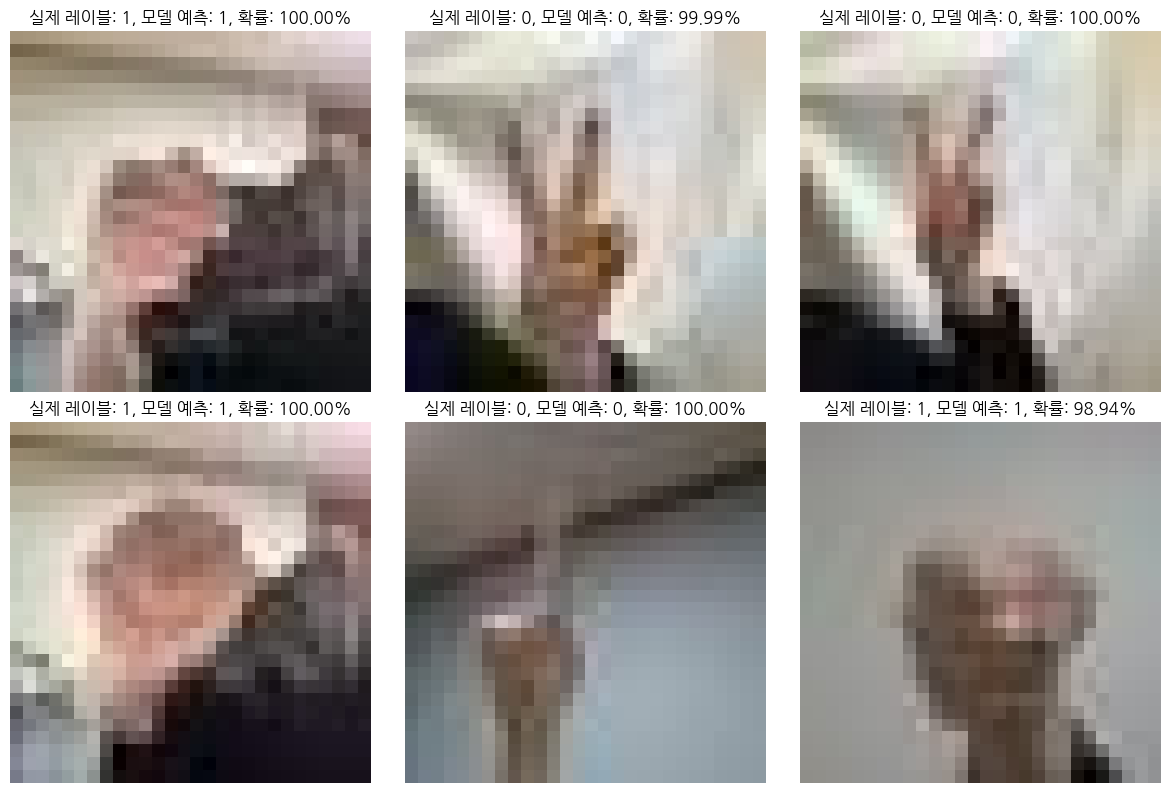

In [ ]:
# 정답을 맞춘 경우 시각화
visualize_model_predictions(model, x_test_new, y_test_new, num_samples=6, correct_predictions=True)

### 모델이 잘못 추정한 데이터의 확률 살펴보기

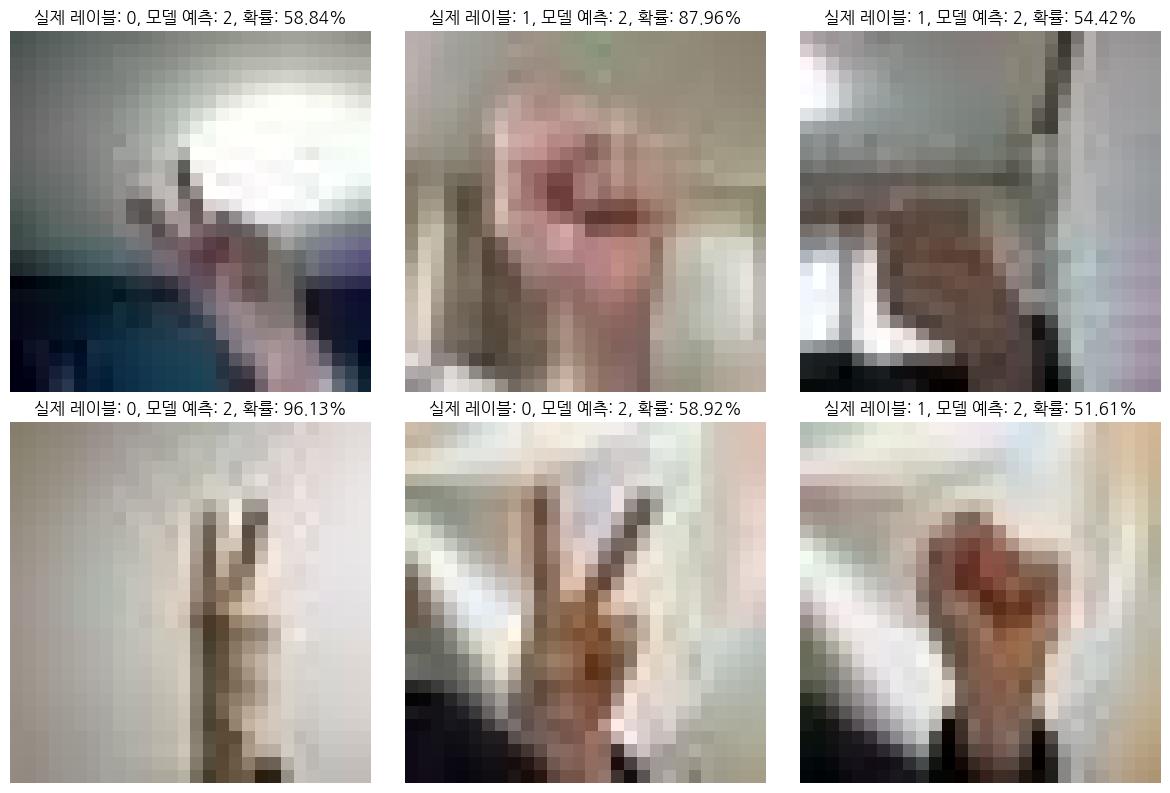

In [ ]:
# 잘못 예측된 경우 시각화
visualize_model_predictions(model, x_test_new, y_test_new, num_samples=6, correct_predictions=False)

# 최종모델 실시간으로 결과 확인하기

In [ ]:
import cv2
import numpy as np

# 웹캠에서 비디오를 캡처합니다.
cap = cv2.VideoCapture(0)

while(True):
    # 현재 프레임을 캡처합니다.
    ret, frame = cap.read()

    # 이미지를 모델의 입력 형태로 변환합니다.
    # 이때, 이미지의 크기, 색상 공간, 정규화 등을 모델이 요구하는 형태로 변환해야 합니다.
    input_image = cv2.resize(frame, (28, 29))
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    input_image = input_image / 255.0
    input_image = np.expand_dims(input_image, axis=0)

    # 이미지에 대한 예측을 수행합니다.
    prediction = model.predict(input_image)
    predicted_class = np.argmax(prediction)

    # 예측 결과를 화면에 표시합니다.
    cv2.putText(frame, f'Predicted class: {predicted_class}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # 프레임을 화면에 표시합니다.
    cv2.imshow('frame', frame)

    # 'q' 키를 누르면 루프에서 탈출합니다.
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# 비디오 캡처를 종료하고 열려 있는 창을 모두 닫습니다.
cap.release()
cv2.destroyAllWindows()

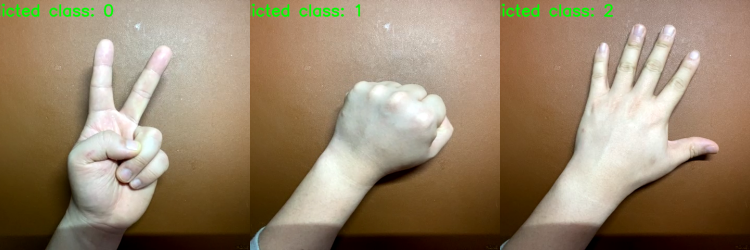

- 위 코드를 실행하면 구글의 [Teachable Machine](https://teachablemachine.withgoogle.com/) 처럼 연결된 웹켐으로 실시간으로 모델이 이미지를 분류하는 것을 확인할 수 있습니다.
- 영상으로 실시간 촬영하는 경우에도 잘 구분하는 것을 확인할 수 있습니다.
- 바위의 경우 앞쪽보다는 뒤쪽을 더 잘 캐치하는 경향이 있긴 했습니다.

---

# Closing
---
---

## 🚦 Summary
- 가위, 바위, 보 이미지를 학습해서 분류하는 모델을 생성하고 개선하는 작업을 진행해 보았습니다.
- 모델 성능 평가를 위해 교차검증을 시도하는 코드를 추가하였습니다.
- 추가 데이터를 늘린것의 결과가 정확도 100%로 나와 테스트 데이터에 대한 데이터 비율을 늘리고 재시도를 하였습니다.
- 데이터를 증가시킨 결과 자체가 98%로 매우 높게 나왔고, 성능 향상을 위해 데이터 증강을 시도했습니다.
- 그 결과 정확도 99.3% 의 모델을 만들 수 있었습니다.
- 그리고 이를 웹캠에 연결해 모델이 실시간으로 결과를 도출하는 과정도 구현해봤습니다.

---
## 회고


### KEEP
- 학습하며 이해했던 개념들을 바탕으로 최적화를 하기 위해 노력했다.
- 단순 정확도를 높이기 위한 시도가 아니라, 각 방법들을 찾아보고 적용하려 했다.
- 이전 퀘스트대보다 데이터를 더 간결하게 했고, 특히 모델 학습결과를 평가하는 함수를 만들었다.
- 생성한 모델을 실시간 이미지 캡쳐까지 까지 구현해봤다.


### PROBLEM
- 모델 결과가 너무 좋게 나와서 다양한 최적화 기법을 시행해보지 못했다.
- 시간 여유가 좀 더 있었다면 데이터 볼륨을 제한하고 다양한 기법들을 시도해보고싶었지만,다른 일때문에 시간이 없어서 시도해보지 못햇다.


### TRY
- 데이터 볼륨을 조금 줄인 후 다양한 성능 개선 기법을 시도해보기.

## Ref.

- [Teachable Machine을 활용한 데이터 생성](https://teachablemachine.withgoogle.com/)
- [Tensorflow MNIST Dataset](https://www.tensorflow.org/datasets/catalog/mnist?hl=ko)
- [Matplotlib 활용사례](https://matplotlib.org/cheatsheets/)
- [Train / Test / Validation 데이터셋의 차이](https://ganghee-lee.tistory.com/38)
- [교차검증(Cross-validation) 필요성 및 장단점](https://heytech.tistory.com/113)
- [이미지데이터의 차원을 변형해주는 reshape](https://supermemi.tistory.com/entry/Python-3-Numpy-reshape-%ED%95%A8%EC%88%98%EB%9E%80)
- [Bayesian Optimization for Neural Architecture Search](https://wikidocs.net/195717)
- [Rock-Paper-Scissors Image Classification Using CNN](https://medium.com/geekculture/rock-paper-scissors-image-classification-using-cnn-eefe4569b415)
- [딥러닝 텐서플로 교과서 Chap. 8 성능 최적화](https://velog.io/@yepark/%EB%94%A5%EB%9F%AC%EB%8B%9D-%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C-%EA%B5%90%EA%B3%BC%EC%84%9C-Chap.-8-%EC%84%B1%EB%8A%A5-%EC%B5%9C%EC%A0%81%ED%99%94#%EC%A1%B0%EA%B8%B0-%EC%A2%85%EB%A3%8C%EB%A5%BC-%EC%9D%B4%EC%9A%A9%ED%95%9C-%EC%84%B1%EB%8A%A5-%EC%B5%9C%EC%A0%81%ED%99%94)
- [Medical Imaging 모델 Fine-tuning 고난기 : 0~1주차 혼란](https://jisuhan.tistory.com/89)
- [Kreas로 K-fold cross validation 하기](https://blog.naver.com/nywoo19/221970913783)
- [[개발팁] 'MultilabelStrarifiedKFold' : Multi-label classification 에 적용 가능한 strarification cross validator](https://cvml.tistory.com/25)
- [층화 샘플링 (StratifiedKFold) -- 데이터 분리 (kfold stratify) - 기존 검증 방법](https://wikidocs.net/43286)